# Lec 03. Transfer Learning with Dogs vs. Cats datasets

이번 실습에서는 Dogs vs Cats 데이터셋의 일부만을 사용하여 transfer learning을 적용한 CNN을 만들어 보겠습니다. 이번 실습은 다음과 같은 내용을 포함합니다.
- Image augmentation
- Simple CNN
- pretrained model
- Fine tuning model

# Dogs vs Cats sample datasets Download

본래 [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data)에는 25,000 개의 개와 고양이 이미지가 들어 있습니다. 25,000개의 이미지를 모두 사용하면 좋은 성능의 모델을 만들 수 있지만, 저희의 목적은 충분하지 못한 데이터셋을 가지고 즉 카테고리 당 이미지의 수가 적다는 제약을 가지고 모델을 만들고자 합니다. 따라서 3,000개의 이미지만을 다운로드 받습니다.


In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-08-05 01:37:36--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.28.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   124MB/s    in 0.5s    

2020-08-05 01:37:36 (124 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
test_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(validation_dir, 'dogs')

## 데이터 확인

In [4]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.939.jpg', 'cat.814.jpg', 'cat.10.jpg', 'cat.557.jpg', 'cat.737.jpg', 'cat.699.jpg', 'cat.113.jpg', 'cat.153.jpg', 'cat.431.jpg', 'cat.372.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [5]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total test cat images: 500
total test dog images: 500


# Image augmentation
Image augmentation은 원본 이미지에 인위적인 변화를 주는 것입니다. 이미지에 인위적으로 변화를 주는 이유는 overfitting을 방지하기 위해 bias를 주는 것 입니다.
이렇게 인위적으로 변화를 준 이미지를 학습에 활용된다면 보다 좋은 성능을 얻을 수 있습니다. 

## ImageDataGenerator
- Zooming the image randomly by a factor of 0.3 using the **zoom_range** parameter.
- Rotating the image randomly by 50 degrees using the **rotation_range** parameter.

- Translating the image randomly horizontally or vertically by a 0.2 factor of the image’s width or height using the **width_shift_range** and the **height_shift_range** parameters.

- Applying shear-based transformations randomly using the **shear_range** parameter.

- Randomly flipping half of the images horizontally using the **horizontal_flip** parameter.

- Leveraging the **fill_mode** parameter to fill in new pixels for images after we apply any of the preceding operations (especially rotation or translation). In this case, we just fill in the new pixels with their nearest surrounding pixel values.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, 
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

## Data loader

In [8]:
# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size= 32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset= 'training')

validation_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size= 32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary',
        subset='validation')

# Flow test images in batches of 32 using val_datagen generator
test_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size= 1,
        class_mode='binary')

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## ImageDataGenerator 통해 생성 된 이미지


Labels: [1.0, 0.0, 1.0, 0.0, 0.0]


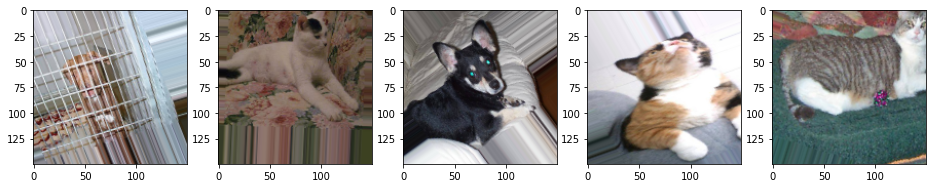

In [9]:
Aug = [next(train_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in Aug])
l = [ax[i].imshow(Aug[i][0][0]) for i in range(0,5)]

## 기존 이미지

Labels: [0.0, 1.0, 1.0, 0.0, 0.0]


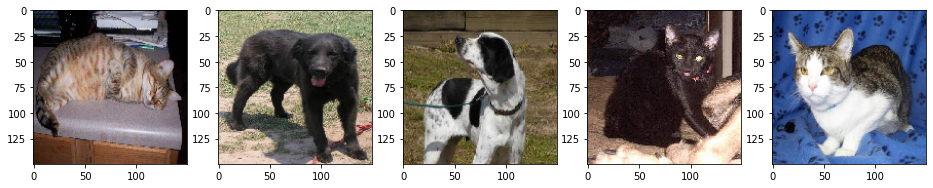

In [ ]:
Aug = [next(test_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in Aug])
l = [ax[i].imshow(Aug[i][0][0]) for i in range(0,5)]

## Basic CNN

In [10]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers
input_shape = (150, 150, 3)

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3)) # Regularization
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3)) # Regularization
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Training

In [12]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch = train_generator.n // train_generator.batch_size, 
                              epochs=30, 
                              validation_data = validation_generator, 
                              validation_steps = validation_generator.n // validation_generator.batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
50/50 [==============================] - 14s 276ms/step - loss: 0.6942 - accuracy: 0.5031 - val_loss: 0.6905 - val_accuracy: 0.4974
Epoch 2/30
50/50 [==============================] - 14s 270ms/step - loss: 0.6905 - accuracy: 0.5163 - val_loss: 0.6883 - val_accuracy: 0.5000
Epoch 3/30
50/50 [==============================] - 14s 272ms/step - loss: 0.6817 - accuracy: 0.5462 - val_loss: 0.6830 - val_accuracy: 0.5156
Epoch 4/30
50/50 [==============================] - 14s 274ms/step - loss: 0.6720 - accuracy: 0.5800 - val_loss: 0.7199 - val_accuracy: 0.5078
Epoch 5/30
50/50 [==============================] - 14s 272ms/step - loss: 0.6618 - accuracy: 0.5987 - val_loss: 0.6625 - val_accuracy: 0.5807
Epoch 6/30
50/50 [==============================] - 14s 276ms/step - loss: 0.6544 - accuracy: 0.5931 - val_loss: 0.6479 - val_accuracy: 0.6042
Epoch 7/30
50/50 [==============================] - 14s 273ms/step

KeyboardInterrupt: ignored

## Visualization

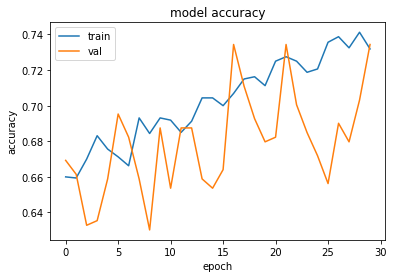

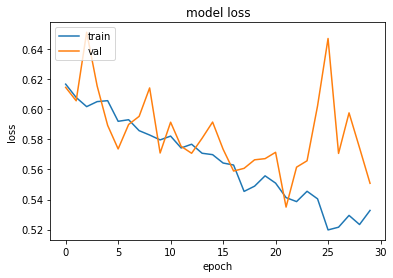

In [ ]:
## summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model save


In [ ]:
model.save('/tmp/cats_dogs_cnn_img_aug.h5')

# Leveraging Transfer Learning with Pre-trained CNN Models

사전 훈련 된 모델은 새 모델을 만들거나 재사용 할 때 다음 두 가지 일반적인 방법으로 사용됩니다.
- 사전 훈련 된 모델을 feature extractor로 사용
- 사전 훈련 된 모델 fine-tuning

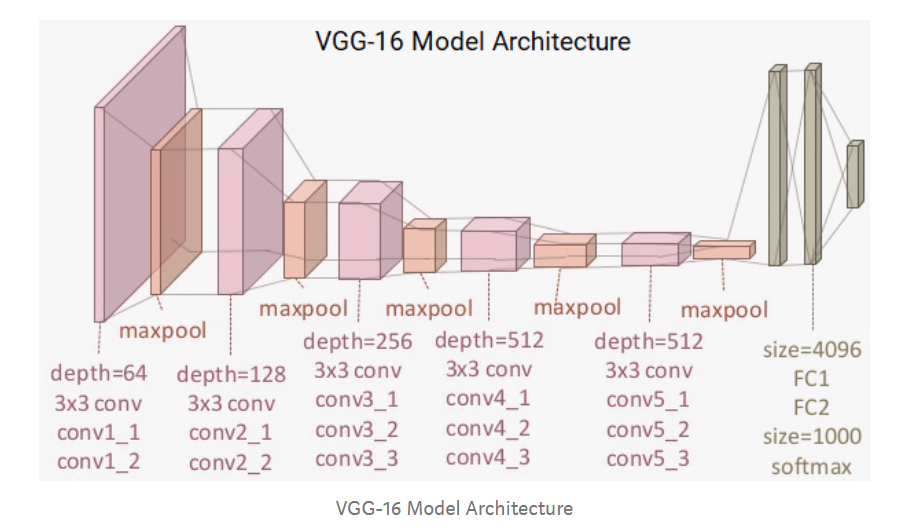

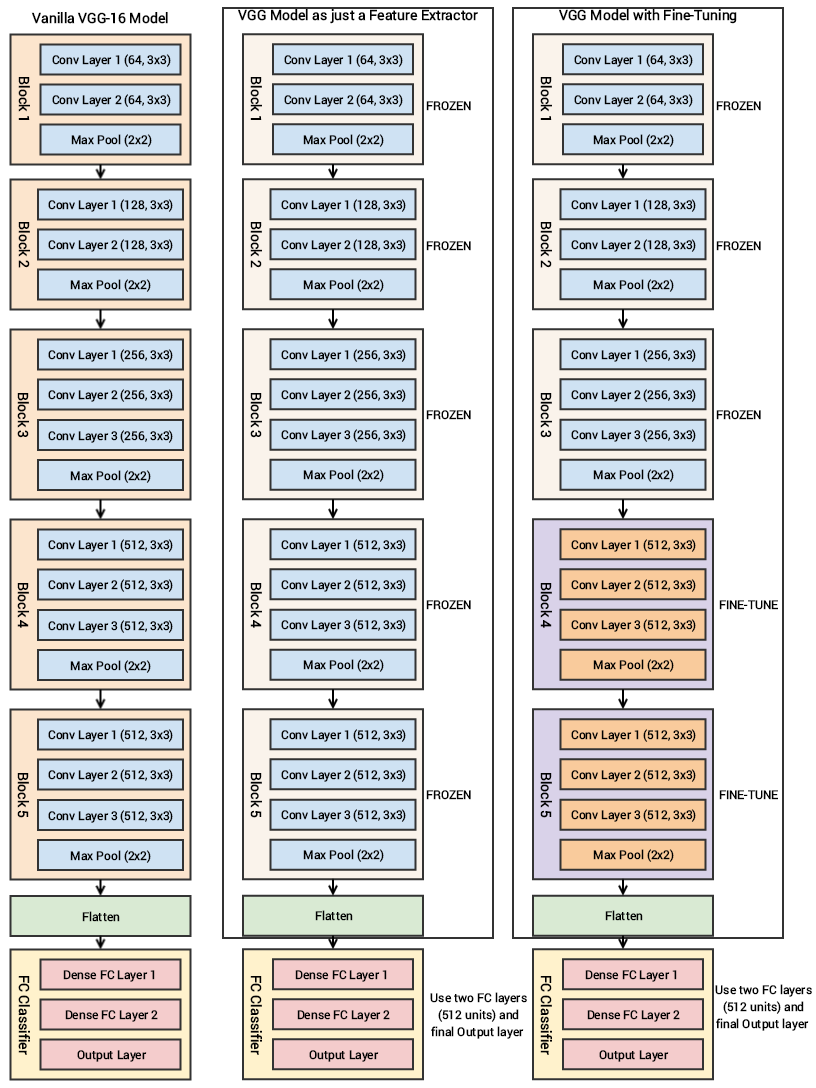

## Pre-trained CNN model as a Feature Extractor

In [13]:
from keras.applications import vgg16
from keras.models import Model
import keras

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    


58892288/58889256 [==============================] - 0s 0us/step


In [14]:
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f775a5b7d68>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f775a3e43c8>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f775a5b7048>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f775a3e4f60>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f775a3e4780>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f775a516c50>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f775a3ed898>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f775a57e048>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f775a516a58>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f775a3f4b70>,block3_conv3,False


In [15]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers


model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 8192)              14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 4,457,985
Non-trainable params: 14,714,688
__________________________________

In [17]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch = train_generator.n // train_generator.batch_size, 
                              epochs=30, 
                              validation_data = validation_generator, 
                              validation_steps = validation_generator.n // validation_generator.batch_size)

Epoch 1/30
 9/50 [====>.........................] - ETA: 9s - loss: 0.4443 - accuracy: 0.7778

KeyboardInterrupt: ignored

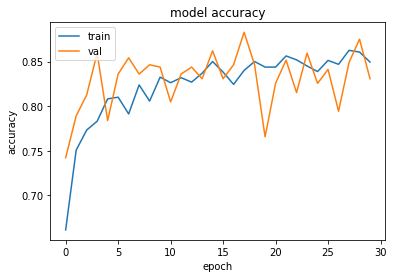

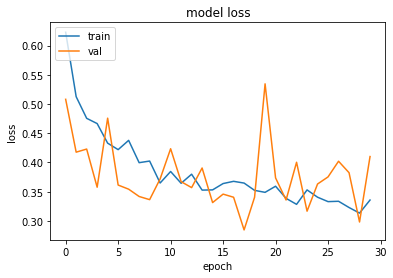

In [ ]:
## summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('/tmp/cats_dogs_tlearn_img_aug_cnn.h5')

## Pre-trained CNN model with Fine-tuning

In [ ]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])   

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7efdba083518>,input_2,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efdb8e0fac8>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efdba660ef0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7efdba6d4be0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efdba6d4358>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efdb8dc7b70>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7efdb8dc7c18>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efdba0c07b8>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efdba0fa630>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efdba0fa710>,block3_conv3,False


In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 8192)              14714688  
_________________________________________________________________
dense_15 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
__________________________________

In [ ]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch = train_generator.n // train_generator.batch_size, 
                              epochs=30, 
                              validation_data = validation_generator, 
                              validation_steps = validation_generator.n // validation_generator.batch_size)

Epoch 1/30
50/50 [==============================] - 16s 328ms/step - loss: 0.7128 - accuracy: 0.5125 - val_loss: 0.6959 - val_accuracy: 0.4974
Epoch 2/30
50/50 [==============================] - 16s 326ms/step - loss: 0.6772 - accuracy: 0.5825 - val_loss: 0.6994 - val_accuracy: 0.5443
Epoch 3/30
50/50 [==============================] - 16s 325ms/step - loss: 0.5951 - accuracy: 0.6975 - val_loss: 0.4724 - val_accuracy: 0.7656
Epoch 4/30
50/50 [==============================] - 16s 324ms/step - loss: 0.5166 - accuracy: 0.7500 - val_loss: 0.4194 - val_accuracy: 0.8594
Epoch 5/30
50/50 [==============================] - 16s 324ms/step - loss: 0.4443 - accuracy: 0.7956 - val_loss: 0.4940 - val_accuracy: 0.7318
Epoch 6/30
50/50 [==============================] - 16s 324ms/step - loss: 0.4719 - accuracy: 0.7919 - val_loss: 0.3275 - val_accuracy: 0.8776
Epoch 7/30
50/50 [==============================] - 16s 325ms/step - loss: 0.4065 - accuracy: 0.8319 - val_loss: 0.3457 - val_accuracy: 0.8750

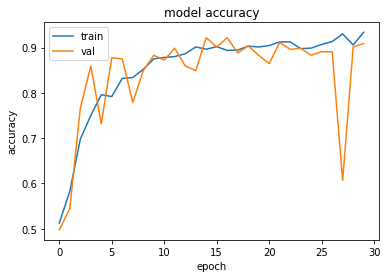

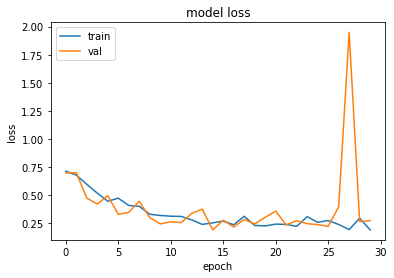

In [ ]:
## summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('/tmp/cats_dogs_tlearn_finetune_img_aug_cnn.h5')

## Evaluating models on Test Data

In [ ]:
from keras.models import load_model
basic_cnn = load_model('/tmp/cats_dogs_cnn_img_aug.h5')
tl_img_aug_cnn = load_model('/tmp/cats_dogs_tlearn_img_aug_cnn.h5')
tl_img_aug_finetune_cnn = load_model('/tmp/cats_dogs_tlearn_finetune_img_aug_cnn.h5')

## Model1: Basic CNN Performance

In [ ]:
scores = basic_cnn.evaluate_generator(test_generator)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

accuracy: 74.00%


## Model 2: Transfer Learning — Pre-trained CNN as a Feature Extractor Performance

In [ ]:
scores = tl_img_aug_cnn.evaluate_generator(test_generator)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

accuracy: 87.60%


## Model 3: Transfer Learning — Pre-trained CNN with Fine-tuning Performance

In [ ]:
scores = tl_img_aug_finetune_cnn.evaluate_generator(test_generator)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

accuracy: 94.80%


# 실습
- [Keras Applications](https://keras.io/api/applications/)에 접속하여 Pre-trained CNN Models 확인
- 3가지 모델(VGG16 / ResNet50 / InceptionV3 ...)을 불러와서 feature extracotr 및 fine-tuning 성능 비교
- CIFAR-10 dataset 이용
- ImageDataGenerator x


In [ ]:
# from keras.datasets import 
# (X_train, y_train), (X_test, y_test) = cifar10.load_data()

## 데이터 정규화: 0 ~ 255 -> 0.0 ~ 1.0(케라스의 성능을 최대화 하기 위함)
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#X_train = X_train / 255.0
#X_test = X_test / 255.0

## 원-핫 인코딩
#y_train = np_utils.to_categorical(y_train)
#y_test = np_utils.to_categorical(y_test)

